<a href="https://colab.research.google.com/github/justinb4003/4003colab/blob/main/Intro_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We're going to make a major leap from lesson 01 to this one and generally blow by a lot of basic Python concepts just to get to something fun (hopefully) and illustrate what we're going to be working with.

Mostly, this is driven by the hopes that if you find something useful you'll continue working with it.  A lot of early learning in programming is done just by altering something you already have and gradually making it do something else.  Eventually details will become important but for now I'm happy to gloss over them.  If you want to drill down into why a [ is being used instead of a ( somewhere, I'm more than happy to.  

But, without knowing a thing about programming if I told you I wrote this so that team Trisonics, team number 4003, had 38 students on the team and we wanted to change that to 34, you could probably sort that change out yourself.

I'm also going to start making comments inline with the code.  Comments, in Python, are lines that start with the # sign.  I'm just doing this otherwise you'd have to press a play button for every single line of code.

In [ ]:
# Here we're importing the pandas library under the 'pd' name
# This is so that when we type pd. (the dot is important, not the end of a 
# sentence) Python knows to look in the Pandas library for the code behind 
# that.  This will probably be at the top of everything you write, likely 
# joined by more imports over time.
import pandas as pd

# Step one is to create some data representing team name, team number, and the 
# number of students on the team
team_data  = [['Trisonics',     4003, 38],
              ['MARS Rovers',   4004, 18],
              ['Killer Bees',     33, 56]]

# Cell doesn't produce output so we print something to signal it finished
print('Data initialized')

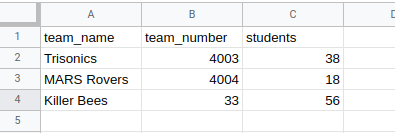


The above is a list within a list, technically, but you can think of it as a 2d grid like a spreadsheet, like in the picture.  The Trisonics line is a 'row' of data and each other team also has their own row of data.  The combined list of the team names is called a column, much like a spreadsheet, and in pandas this can be called a Series at times in the technical documentation.


In [ ]:
# Now we turn this raw data into a Pandas dataframe
df = pd.DataFrame(team_data, columns=['team_name', 'team_number', 'students'])
# The above is calling a function and storing the return value in 'df'
# Programming functions are very much like math functions such as
# y = f(x) or y = f(x, z) where you feed a function some parameters and it 
# returns a value.  In this case we fed it our data structure and a list of 
# strings to use as column names.

# At point in our code 'df' represents the general idea of the spreasheet
# image above, and we can do spreadsheet type things to do that very easily.

# For instance if we want the average number of studnets on a team we would
# do this:
avg_students = df['students'].mean()
# Minimum number of students on a team
min_students = df['students'].min()
# Maximum number of students on a team
max_students = df['students'].max()

# Activate debugger tool to inspect values!
print(avg_students, min_students, max_students)

In [ ]:
# We can just look at the df itself too... looks like a spreadsheet!
df

In [ ]:
# I wonder what the average team name is...
df['team_name'].mean()

Well, the answer is nothing fun.  This is what happens with an exception is thrown, or as you can think of it, when your program blows up.

In this case it's angry because we asked for the mean value of the team name and it can't conver Trisonics, MARS Rovers, or Killer Bees to numeric values.  It's an entirely reasonable complaint but it is rather cryptic about it.

The 'Search Stack Overflow' button can be handy, though it's hard to sort through the responses to determine what answer(s) apply to you, if any, when beginning.


In [ ]:
# This entire cell sets up "helper" functions.
# Step one is to pull in a new library via the pip command line tool.
# Prefixing a line with a ! (bang!) mark tells the notebook environment to
# run this on a command line, not as part of the Python code.
!pip install fsspec

# To pull data from The Blue Alliance we'll use their API available via HTTP
# In short we make an HTTP request (like your web browser does to retrieve
# a web page, or update an app) that goes somewhere like this:
# https://www.thebluealliance.com/api/v3/teams/2020/0
# ... which tells TBA we'd like a list of TEAMS from 2020 and show us page 0
# That returns a JSON document which is a programming-friendly way of
# communicating structured data between systems.
# The response will look something like this:
"""
  {
    "key": "frc4003",
    "team_number": 4003,
    "nickname": "TriSonics",
    etc...
"""
# But you don't really see that; we'll just pop it into a dataframe as a nice
# handy container for us to use.

import io
import json
import requests

def get_tba_url_as_df(url):
  """
  Retrieves a URL from The Blue Alliance and converts it to a dataframe
  """
  tba = 'https://www.thebluealliance.com/api/v3'
  # We must specify this extra HTTP header so TBA knows what account is
  # accessing the data.
  headers = {'X-TBA-Auth-Key': 'VUdGT41tnb2MLMfXSX0QvPSDDyi0aMVzmxLTWar8wjCmZvNFZfZiq7sHfhAtWgbO'}
  full_url = f'{tba}{url}'
  # Uncomment this to see the URL you'r trying to contact.  Sometimes a simple
  # mistake like having two slashes (//) instead of one (/) means the server
  # can't process your request.
  # print(f'Retrieving {full_url}')
  r = requests.get(full_url, headers=headers)
  json_data = r.text
  df = pd.read_json(io.StringIO(json_data))
  return df 


def get_teams_df(year):
    """
    Repeatedly calls the teams/<year>/X URL to build a complete dataframe with
    all FRC team data that TBA has
    
    Parameters:
    -----------
        year: str
            Year to locate active teams 
    Returns:
    --------
    DataFrame
        DataFrame will contain every team found for the given year
    """


    # Initiailize our dataframe object to a simple None value, which means
    # nothing, null, zero, blank, something akin to that.
    teams_df = None

    # We keep a running count of how many teams we've discovered to determine
    # when we should stop.
    full_team_count = 0
    last_team_count = 0
    # We'll hard-code a maximum of 25 pages of results that we will look at.
    # That sets the upper team number limit at 25 * 500 = 12,500.  We're safe for now.
    for page_index in range(25):
        partial_df = get_tba_url_as_df(f'/teams/{year}/{page_index}') 
        
        # If teams_df is still None that means this is our first pass through
        # the data and we'll use our partial dataframe of data to initialize
        # the final one
        if teams_df is None:
            teams_df = partial_df
        # Else, if it wasn't the first time through, we have the final
        # dataframe already started, so we need to append() the partial one
        # to the largert one
        else:
            teams_df = teams_df.append(partial_df)
        
        # Now we take a count of how many teams we've found so far.
        # It's a little odd, because we're useing teams_df.index which
        # returns and index number for each row of data, then taking the
        # length/len() of that to get the total count.
        full_team_count = len(teams_df.index)
        
        # If we've still got the seame number of teams that we had on the
        # last run through this loop then we must be done.
        if full_team_count != last_team_count:
            last_team_count = full_team_count
        else:
            break
    return teams_df

def get_team_events_df(team_key, year):
    """
    Parameters:
    -----------
        team_key: str
            TBA key for a team. Example: 'frc4003'
        year: str
            Year of events we're looking for
    Returns:
    --------
    DataFrame
        DataFrame contains information on every event a team participated in
        for the given year.
    """
    df = get_tba_url_as_df(f'/team/{team_key}/events/{year}')
    return df

def get_event_df(event_key):
    """
    Parameters:
    -----------
        team_key: str
            TBA key for a team. Example: 'frc4003'
        year: str
            Year of events we're looking for
    Returns:
    --------
    DataFrame
        DataFrame contains information on every event a team participated in
        for the given year.
    """
    df = get_tba_url_as_df(f'/event/{event_key}/simple')
    return df

def get_event_matches_df(event_key):
    """
    Parameters:
    -----------
        event_key: str
            TBA key for an event. Example: '2020misjo'
    Returns:
    --------
    DataFrame
        DataFrame contains information on every match for the given event key.
    """
    df = get_tba_url_as_df(f'/event/{event_key}/matches')
    return df

def get_events_df(year):
    """
    Parameters:
    -----------
        year: str
            Year of events we're looking for
    Returns:
    --------
    DataFrame
        DataFrame contains information on every event in a year.
    """
    df = get_tba_url_as_df(f'/events/{year}')
    return df


print('Execution completed!')

In [ ]:
# Use our helper function get_teams_df() to get a dataframe with every
# team in it
teams_df = get_teams_df('2020')

In [ ]:
# Now let's filter down the team list to our own record
condition = teams_df['team_number'] == 4003
team4003 = teams_df[condition]
team4003

In [ ]:
# And then extract our 'key' from it that we use to find our events
# Here we take the first and only row in the teams4003 dataframe
# which is row 0, and extract the value for the 'key' column.
key4003 = team4003.iloc[0]['key']
print(f'Key for 4003: {key4003}')

# Or for now I'll skip the lookup process because our key is pretty easy
# to remember.
# key4003 = 'frc4003'
events_df = get_team_events_df(key4003, '2020')
events_df

In [ ]:
# Let's look at our MI St Joe matches
matches_df = get_event_matches_df('2020misjo')
matches_df

Well, that's kind of fun.  There's a predicted_time value for each match and an actual_time value. If you were taking a look at this data in a spreadsheet you could make another column with a calculated formula, and we can do something like that here in Python/Pandas too.

In [ ]:
# Let's make a column that has the difference between the actual start time 
# and predicted time  in minutes.
from datetime import timedelta
matches_df['timediff_minutes'] = (matches_df['actual_time'] - matches_df['predicted_time'])/timedelta(minutes=1)
# Now we have a new column in our dataframe called timediff_minutes.
# Let's look at it.
matches_df

In [ ]:
matches_df['timediff_minutes'].mean()

Well, that was neat.  We can pull some data from the internet and do things with it!  Now, you could have probably pulled that data and dropped it into a spreadsheet and found the answer to this problem pretty easy, but let's do it for every event in the system for the year!

In [ ]:
from datetime import timedelta

match_delay = {} # Create an empty dict.  Lesson 1.5 (optional) covers these
events_df = get_events_df('2020')
for event_key in events_df['key']:
    event_matches = get_event_matches_df(event_key)
    # Skip trying to process if it we get an empty record.
    if len(event_matches.index) == 0:
        continue;

    event_matches['timediff_minutes'] = (event_matches['actual_time'] - event_matches['predicted_time'])/timedelta(minutes=1)
    match_average =  event_matches['timediff_minutes'].mean()
    # Only keep the match_average value if we return an actual number
    # Some events have incorrect values for actual_time and they don't compute
    # properly.
    if not pd.isnull(match_average):
        match_delay[event_key] = match_average

Well, that's kind of fun!  We now have a dictionary listing every event code and their average match delay time.

In [ ]:
match_delay